In [1]:
# === Cell 1: load a single-k transition table (robust to file naming) ===
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

BASE = "../data/models/markov_v2"

def _load_first_match(patterns, base=BASE):
    for pat in patterns:
        hits = sorted(glob.glob(os.path.join(base, pat)))
        if hits:
            path = hits[0]
            if path.endswith(".parquet"):
                return pd.read_parquet(path), path
            if path.endswith(".csv"):
                return pd.read_csv(path), path
    raise FileNotFoundError(
        f"No file matched. Looked in {base} for: {patterns}"
    )

# Adjust patterns if your artifact uses different naming
df, used_path = _load_first_match([
    "*transition*.*",
    "*kernel*.*",
    "*Pk*.*",
    "*markov*trans*.*",
])

print("Loaded:", used_path)
print(df.columns)
df.head()


Loaded: ../data/models/markov_v2/markov_transition_probs.parquet
Index(['purchase_k', 'S_k_key', 'S_next_key', 'n', 'n_from', 'p'], dtype='object')


,purchase_k,S_k_key,S_next_key,n,n_from,p
0,2,CO2,CO2,212,250,0.848
1,2,CO2,"CO2, PushAir",21,250,0.084
2,2,CO2,"CO2, PushAir, bottle",2,250,0.008
3,2,CO2,"CO2, PushAir, bottle, pitcher",1,250,0.004
4,2,CO2,"CO2, PushAir, container",1,250,0.004


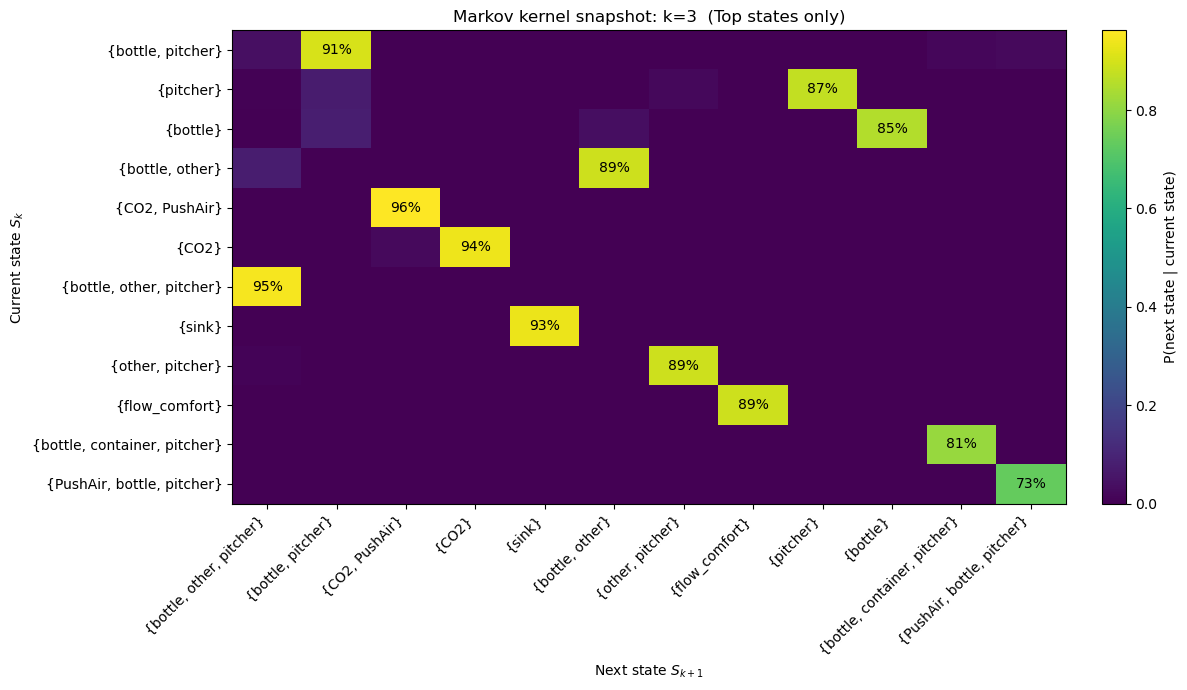

In [5]:
# === Cell 2: single-k heatmap over top states ===

# ---- REQUIRED column mapping ----
# Expecting something like: k, S_k, S_k1, p (and optionally n / count)
# If your column names differ, just edit these 4 lines.
K_COL  = "purchase_k"
S_COL  = "S_k_key"
SP_COL = "S_next_key"
P_COL  = "p"

k = 3                  # choose the step you want to show
top_n_states = 12      # rows (current states)
top_m_next   = 12      # cols (next states)

def short_state(s, max_len=38):
    # nice readable label for sets; tweak if your state encoding differs
    if not isinstance(s, str):
        s = str(s)
    s = s.replace("{", "").replace("}", "")
    s = s.replace("'", "")
    s = "{" + s + "}"
    return s if len(s) <= max_len else s[: max_len-2] + "…}"

step = df[df[K_COL] == k].copy()

# rank current states by how often they appear (fallback: sum of outgoing mass)
if "n" in step.columns:
    cur_rank = step.groupby(S_COL)["n"].sum().sort_values(ascending=False)
else:
    cur_rank = step.groupby(S_COL)[P_COL].sum().sort_values(ascending=False)

top_states = cur_rank.head(top_n_states).index.tolist()
step = step[step[S_COL].isin(top_states)].copy()

# limit columns to most common next states among these rows
next_rank = step.groupby(SP_COL)[P_COL].sum().sort_values(ascending=False)
top_next = next_rank.head(top_m_next).index.tolist()
step = step[step[SP_COL].isin(top_next)].copy()

# pivot to matrix
mat = step.pivot_table(index=S_COL, columns=SP_COL, values=P_COL, aggfunc="sum").fillna(0.0)

# reorder rows/cols by mass to make it visually clean
mat = mat.loc[mat.sum(axis=1).sort_values(ascending=False).index,
              mat.sum(axis=0).sort_values(ascending=False).index]

# plot
plt.figure(figsize=(12, 7))
im = plt.imshow(mat.values, aspect="auto")
plt.colorbar(im, fraction=0.046, pad=0.04, label="P(next state | current state)")

plt.yticks(range(mat.shape[0]), [short_state(x) for x in mat.index])
plt.xticks(range(mat.shape[1]), [short_state(x) for x in mat.columns], rotation=45, ha="right")

# annotate only “meaningful” probabilities
for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
        v = mat.iat[i, j]
        if v >= 0.10:
            plt.text(j, i, f"{v:.0%}", ha="center", va="center")

plt.title(f"Markov kernel snapshot: k={k}  (Top states only)")
plt.xlabel("Next state $S_{k+1}$")
plt.ylabel("Current state $S_k$")
plt.tight_layout()
plt.show()


In [10]:
# canonical column names (locked)
K_COL  = "purchase_k"
S_COL  = "S_k_key"
SP_COL = "S_next_key"
P_COL  = "p"
W_COL  = "n_from"   # <-- locked as state mass

def state_size(s):
    return len(s.replace("{","").replace("}","").split(","))

df["_size_k"]  = df[S_COL].apply(state_size)
df["_size_k1"] = df[SP_COL].apply(state_size)
df["_expanded"] = df["_size_k1"] > df["_size_k"]

def expansion_prob_at_k(g):
    # population weight of each state
    w = g.groupby(S_COL)[W_COL].first()
    w = w / w.sum()

    # expansion probability conditional on state
    p_expand_given_state = (
        g[g["_expanded"]]
        .groupby(S_COL)[P_COL]
        .sum()
        .reindex(w.index, fill_value=0.0)
    )

    return np.sum(w * p_expand_given_state)

expansion_by_k = (
    df.groupby(K_COL)
      .apply(expansion_prob_at_k)
      .rename("p_expand")
      .reset_index()
)

expansion_by_k


/var/folders/2w/84n_l6ld0kq5y9sp9jw4q50c0000gn/T/ipykernel_43220/1957395519.py:32: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(expansion_prob_at_k)


,purchase_k,p_expand
0,2,0.149664
1,3,0.125526
2,4,0.102496
3,5,0.089581
4,6,0.074144
5,7,0.064286
6,8,0.084416
7,9,0.052083
8,10,0.064516
9,11,0.023256


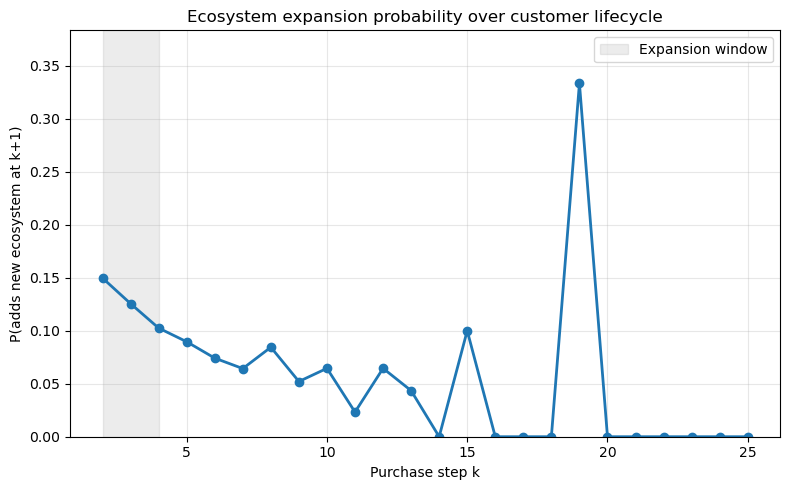

In [11]:
plt.figure(figsize=(8, 5))

plt.plot(
    expansion_by_k[K_COL],
    expansion_by_k["p_expand"],
    marker="o",
    linewidth=2
)

plt.axvspan(2, 4, color="grey", alpha=0.15, label="Expansion window")

plt.xlabel("Purchase step k")
plt.ylabel("P(adds new ecosystem at k+1)")
plt.title("Ecosystem expansion probability over customer lifecycle")

plt.ylim(0, expansion_by_k["p_expand"].max() * 1.15)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
def dominant_ecosystem(state):
    # assumes comma-separated set encoding
    return state.replace("{","").replace("}","").split(",")[0].strip()

df["_ecosystem"] = df[S_COL].apply(dominant_ecosystem)

records = []

for eco, g in df.groupby("_ecosystem"):
    # population weight
    w = g.groupby(S_COL)["n_from"].first()
    w = w / w.sum()

    # stickiness per state
    p_stay = (
        g[g[S_COL] == g[SP_COL]]
        .groupby(S_COL)[P_COL]
        .sum()
        .reindex(w.index, fill_value=0)
    )

    # expansion per state
    p_expand = (
        g[g["_expanded"]]
        .groupby(S_COL)[P_COL]
        .sum()
        .reindex(w.index, fill_value=0)
    )

    records.append({
        "ecosystem": eco,
        "stickiness": np.sum(w * p_stay),
        "expansion": np.sum(w * p_expand),
        "mass": g["n_from"].sum()
    })

eco_df = pd.DataFrame(records)
eco_df



,ecosystem,stickiness,expansion,mass
0,CO2,13.693445,0.600760,6932
1,Proskin,1.171875,0.203125,54
2,PushAir,4.702218,1.733679,4145
3,bottle,10.065832,1.100022,186294
4,container,5.314939,0.653565,1961
5,flow_comfort,5.243743,1.425047,5357
6,keton,4.556757,0.308108,123
7,other,14.796712,0.721536,3234
8,pitcher,15.715746,2.008103,53806
9,sink,10.476328,1.523672,5308


In [16]:
import matplotlib.pyplot as plt

def plot_ecosystem_tradeoff(
    df,
    stickiness_col,
    expansion_col,
    mass_col="mass",
    label_col="ecosystem",
    title="Ecosystem roles: lock-in vs growth",
    size_scale=1200
):
    """
    Scatter plot of stickiness vs expansion with bubble size by mass.
    """

    plt.figure(figsize=(9, 6))

    sizes = df[mass_col] / df[mass_col].max() * size_scale

    plt.scatter(
        df[stickiness_col],
        df[expansion_col],
        s=sizes,
        alpha=0.7
    )

    for _, r in df.iterrows():
        plt.text(
            r[stickiness_col] + 0.005,
            r[expansion_col] + 0.005,
            r[label_col],
            fontsize=10
        )

    plt.axhline(df[expansion_col].median(), color="grey", linestyle="--", alpha=0.4)
    plt.axvline(df[stickiness_col].median(), color="grey", linestyle="--", alpha=0.4)

    plt.xlabel("Stickiness  P(Sₖ₊₁ = Sₖ)")
    plt.ylabel("Expansion  P(|Sₖ₊₁| > |Sₖ|)")
    plt.title(title)

    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


In [17]:
# canonical columns (locked)
K_COL  = "purchase_k"
S_COL  = "S_k_key"
SP_COL = "S_next_key"
P_COL  = "p"
W_COL  = "n_from"

def dominant_ecosystem(state):
    return state.replace("{","").replace("}","").split(",")[0].strip()

df["_ecosystem"] = df[S_COL].apply(dominant_ecosystem)

rows = []

for (eco, k), g in df.groupby(["_ecosystem", K_COL]):

    # state weights within this (eco, k)
    w = g.groupby(S_COL)[W_COL].first()
    w = w / w.sum()

    # stickiness at k
    p_stay = (
        g[g[S_COL] == g[SP_COL]]
        .groupby(S_COL)[P_COL]
        .sum()
        .reindex(w.index, fill_value=0.0)
    )

    # expansion at k
    p_expand = (
        g[g["_expanded"]]
        .groupby(S_COL)[P_COL]
        .sum()
        .reindex(w.index, fill_value=0.0)
    )

    rows.append({
        "ecosystem": eco,
        "purchase_k": k,
        "stickiness_k": float((w * p_stay).sum()),
        "expansion_k": float((w * p_expand).sum()),
        "mass_k": g[W_COL].sum()
    })

eco_k = pd.DataFrame(rows)

eco_probs = (
    eco_k
    .assign(weight=lambda x: x["mass_k"] / x.groupby("ecosystem")["mass_k"].transform("sum"))
    .groupby("ecosystem")
    .apply(lambda g: pd.Series({
        "stickiness_prob": (g["weight"] * g["stickiness_k"]).sum(),
        "expansion_prob":  (g["weight"] * g["expansion_k"]).sum(),
        "mass": g["mass_k"].sum()
    }))
    .reset_index()
)

eco_probs



/var/folders/2w/84n_l6ld0kq5y9sp9jw4q50c0000gn/T/ipykernel_43220/253918013.py:51: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,ecosystem,stickiness_prob,expansion_prob,mass
0,CO2,0.883566,0.116434,6932.0
1,Proskin,0.846931,0.153069,54.0
2,PushAir,0.723104,0.276896,4145.0
3,bottle,0.867116,0.132884,186294.0
4,container,0.804238,0.195762,1961.0
5,flow_comfort,0.874768,0.125232,5357.0
6,keton,0.881533,0.118467,123.0
7,other,0.852077,0.147923,3234.0
8,pitcher,0.837099,0.162901,53806.0
9,sink,0.907121,0.092879,5308.0


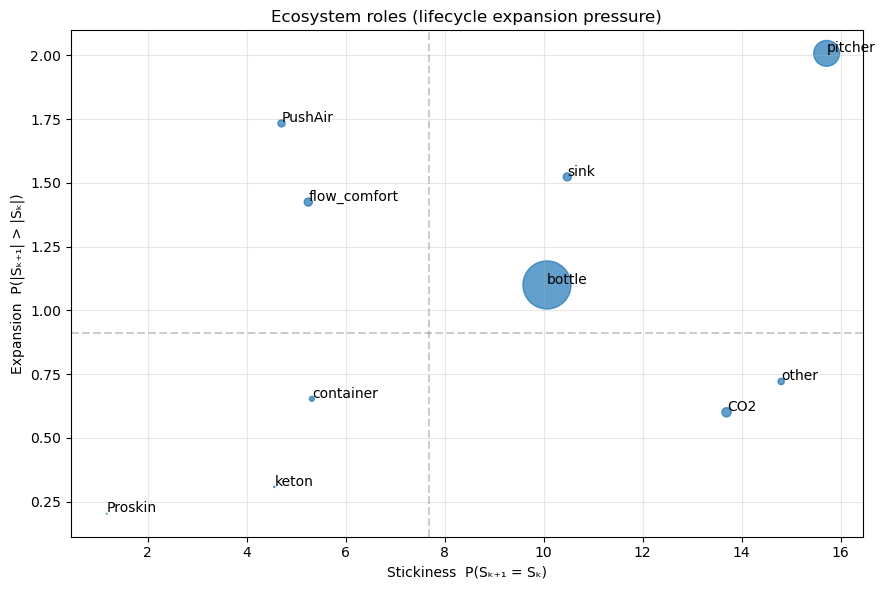

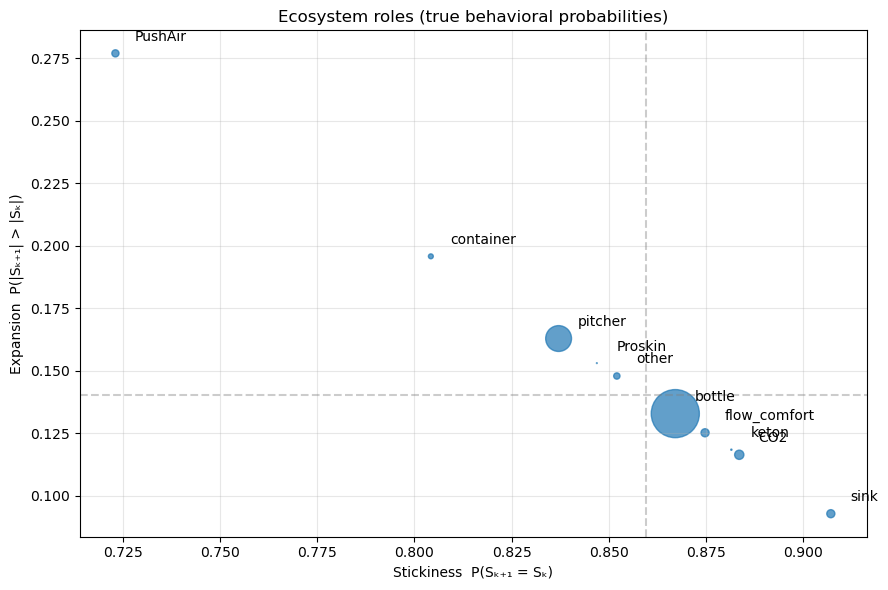

In [18]:
plot_ecosystem_tradeoff(
    eco_df,
    stickiness_col="stickiness",
    expansion_col="expansion",
    mass_col="mass",
    title="Ecosystem roles (lifecycle expansion pressure)"
)

plot_ecosystem_tradeoff(
    eco_probs,
    stickiness_col="stickiness_prob",
    expansion_col="expansion_prob",
    mass_col="mass",
    title="Ecosystem roles (true behavioral probabilities)"
)


/var/folders/2w/84n_l6ld0kq5y9sp9jw4q50c0000gn/T/ipykernel_43220/3039085946.py:38: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g[P_COL] * g["n_from"]).sum())


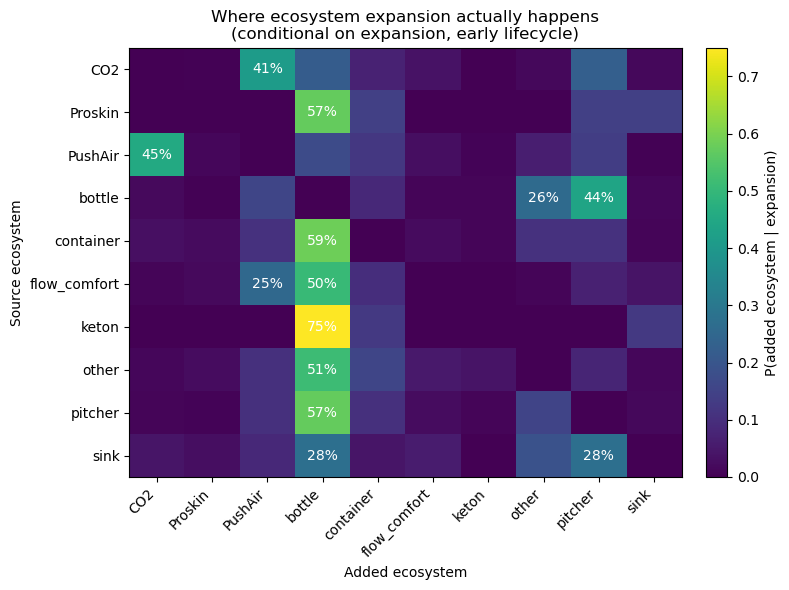

In [26]:
# assumes df already contains:
# purchase_k, S_k_key, S_next_key, p, n_from, _expanded

def dominant_ecosystem(state):
    return state.replace("{","").replace("}","").split(",")[0].strip()

def added_ecosystems(row):
    s0 = set(e.strip() for e in row[S_COL].strip("{}").split(","))
    s1 = set(e.strip() for e in row[SP_COL].strip("{}").split(","))
    return list(s1 - s0)


exp_df = df[df["_expanded"]].copy()

exp_df["eco_from"] = exp_df[S_COL].apply(dominant_ecosystem)
exp_df["eco_added_list"] = exp_df.apply(added_ecosystems, axis=1)

exp_df = exp_df.explode("eco_added_list")
exp_df = exp_df.rename(columns={"eco_added_list": "eco_added"})


# drop ambiguous multi-add cases (rare, keeps story clean)
exp_df = exp_df[exp_df["eco_added"].notna()]

K_MIN, K_MAX = 2, 6

exp_df = exp_df[
    (exp_df[K_COL] >= K_MIN) &
    (exp_df[K_COL] <= K_MAX)
]

import numpy as np
import pandas as pd

mat = (
    exp_df
    .groupby(["eco_from", "eco_added"])
    .apply(lambda g: (g[P_COL] * g["n_from"]).sum())
    .rename("mass")
    .reset_index()
)

mat_p = mat.pivot(
    index="eco_from",
    columns="eco_added",
    values="mass"
).fillna(0)

mat_p = mat_p.div(mat_p.sum(axis=1), axis=0)


import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
im = plt.imshow(mat_p.values, aspect="auto")

plt.colorbar(
    im,
    fraction=0.046,
    pad=0.04,
    label="P(added ecosystem | expansion)"
)

plt.xticks(
    range(len(mat_p.columns)),
    mat_p.columns,
    rotation=45,
    ha="right"
)
plt.yticks(
    range(len(mat_p.index)),
    mat_p.index
)

plt.title(
    "Where ecosystem expansion actually happens\n"
    "(conditional on expansion, early lifecycle)"
)
plt.xlabel("Added ecosystem")
plt.ylabel("Source ecosystem")

# annotate strong flows only
for i in range(mat_p.shape[0]):
    for j in range(mat_p.shape[1]):
        v = mat_p.iloc[i, j]
        if v >= 0.25:
            plt.text(j, i, f"{v:.0%}", ha="center", va="center", color="white")

plt.tight_layout()
plt.show()


In [37]:
# A state is expandable if it EVER leads to expansion
expandable_states = (
    df[df["_expanded"]]
    .groupby(S_COL)[P_COL]
    .sum()
)

expandable_states = set(expandable_states[expandable_states > 0].index)

rows = []

for k, g in df.groupby(K_COL):
    # state mass at k
    w = g.groupby(S_COL)["n_from"].first()
    w = w / w.sum()

    alive_mass = w[w.index.isin(expandable_states)].sum()

    rows.append({
        "purchase_k": k,
        "p_expandable": alive_mass
    })

survival_df = pd.DataFrame(rows).sort_values("purchase_k")
survival_df



,purchase_k,p_expandable
0,2,0.996537
1,3,0.992729
2,4,0.988414
3,5,0.980526
4,6,0.967681
5,7,0.957143
6,8,0.961039
7,9,0.937500
8,10,0.951613
9,11,0.906977


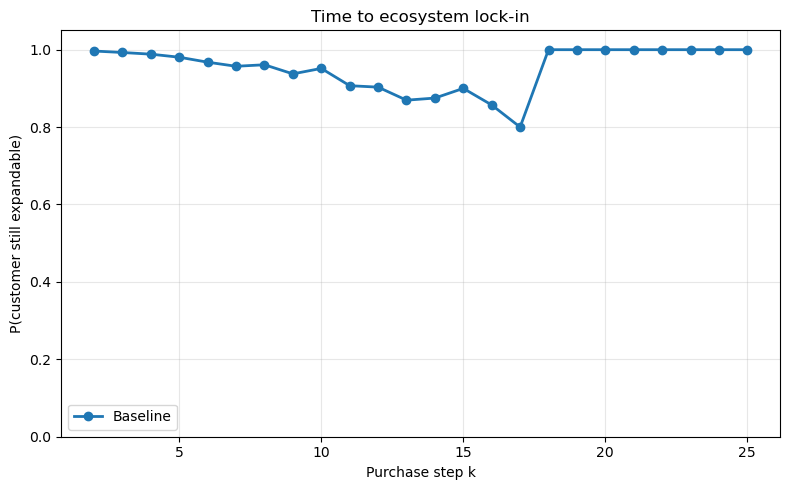

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

plt.plot(
    survival_df["purchase_k"],
    survival_df["p_expandable"],
    marker="o",
    linewidth=2,
    label="Baseline"
)

plt.xlabel("Purchase step k")
plt.ylabel("P(customer still expandable)")
plt.title("Time to ecosystem lock-in")

plt.ylim(0, 1.05)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [39]:
def dominant_ecosystem(state):
    return state.replace("{","").replace("}","").split(",")[0].strip()

def has_expanded(state):
    return len(state.strip("{}").split(",")) > 1

df["_dom"] = df[S_COL].apply(dominant_ecosystem)
df["_expanded_flag"] = df[S_COL].apply(has_expanded)

df["_state_label"] = list(zip(df["_dom"], df["_expanded_flag"]))


In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# locked columns
K_COL  = "purchase_k"
S_COL  = "S_k_key"
SP_COL = "S_next_key"
P_COL  = "p"
W_COL  = "n_from"

def dominant_ecosystem(state: str) -> str:
    return state.strip("{}").split(",")[0].strip()

def has_expanded(state: str) -> bool:
    parts = [x.strip() for x in state.strip("{}").split(",") if x.strip()]
    return len(parts) > 1

def node_label_from_state(state: str) -> str:
    dom = dominant_ecosystem(state)
    exp = has_expanded(state)
    return f"{dom} | {'expanded' if exp else 'base'}"


In [53]:
def build_lifecycle_flow_from_k2(
    df: pd.DataFrame,
    entry_dom: str,
    k_start: int = 2,
    k_max: int = 6,
    keep_mass: float = 0.95,
    edge_min: float = 0.02
):
    """
    TEMP VERSION:
    Builds a lifecycle map starting directly from k=2.
    Entry is defined by dominant ecosystem at k=2.
    States are simplified to (dominant, expanded_flag).
    """

    def prune(mass):
        mass = mass.sort_values(ascending=False)
        keep = mass.cumsum() <= keep_mass
        if not keep.any():
            keep.iloc[0] = True
        return mass[keep] / mass[keep].sum()

    nodes = []
    edges = []

    # ---------- INITIAL STATE (k=2) ----------
    g0 = df[df[K_COL] == k_start].copy()
    w0 = g0.groupby(S_COL)[W_COL].first().astype(float)

    idx = [s for s in w0.index if dominant_ecosystem(s) == entry_dom]
    if len(idx) == 0:
        raise ValueError(f"No states at k=2 with dominant='{entry_dom}'")

    mass_full = w0.loc[idx]
    mass_full = mass_full / mass_full.sum()

    # record entry layer as step = 1
    nodes.append(
        pd.DataFrame({
            "step": 1,
            "node": [node_label_from_state(s) for s in mass_full.index],
            "mass": mass_full.values
        })
        .groupby(["step", "node"])["mass"].sum()
        .reset_index()
    )

    # ---------- FORWARD UNFOLD ----------
    for k in range(k_start, k_max):
        tk = df[df[K_COL] == k].copy()
        tk = tk[tk[S_COL].isin(mass_full.index)]

        if tk.empty:
            break

        tk = tk.merge(
            mass_full.rename("mass_from"),
            left_on=S_COL,
            right_index=True,
            how="left"
        )

        tk["edge_mass"] = tk["mass_from"] * tk[P_COL]

        mass_next = tk.groupby(SP_COL)["edge_mass"].sum()
        if mass_next.sum() == 0:
            break

        mass_next = prune(mass_next)

        # simplified edges
        tk = tk[tk[SP_COL].isin(mass_next.index)].copy()
        tk["src_node"] = tk[S_COL].apply(node_label_from_state)
        tk["dst_node"] = tk[SP_COL].apply(node_label_from_state)

        e = (
            tk.groupby(["src_node", "dst_node"])["edge_mass"]
            .sum()
            .rename("mass")
            .reset_index()
            .assign(step=k - k_start + 1)
        )

        if not e.empty:
            edges.append(e)

        # record nodes
        nodes.append(
            pd.DataFrame({
                "step": k - k_start + 2,
                "node": [node_label_from_state(s) for s in mass_next.index],
                "mass": mass_next.values
            })
            .groupby(["step", "node"])["mass"].sum()
            .reset_index()
        )

        mass_full = mass_next

    nodes_df = pd.concat(nodes, ignore_index=True)

    if edges:
        edges_df = pd.concat(edges, ignore_index=True)
        edges_df = edges_df[edges_df["mass"] >= edge_min]
    else:
        edges_df = pd.DataFrame(columns=["step", "src_node", "dst_node", "mass"])

    return nodes_df, edges_df


In [59]:
NODE_ORDER = [
    "bottle | base",
    "bottle | expanded",
    "pitcher | base",
    "pitcher | expanded",
    "sink | base",
    "sink | expanded",
    "other | base",
    "other | expanded",
]

In [64]:
def plot_lifecycle_map(nodes_df: pd.DataFrame, edges_df: pd.DataFrame, title: str):
    nodes_df = nodes_df.copy()

    # order nodes within each step by mass
    nodes_df["order"] = nodes_df["node"].apply(
    lambda x: NODE_ORDER.index(x) if x in NODE_ORDER else len(NODE_ORDER)
)

    nodes_df = nodes_df.sort_values(["step", "order"])

    # vertical stacking
    spans = []
    for step, g in nodes_df.groupby("step"):
        y = 0.0
        for _, r in g.iterrows():
            spans.append({
                "step": step,
                "node": r["node"],
                "y0": y,
                "y1": y + r["mass"],
                "ymid": y + r["mass"] / 2,
                "mass": r["mass"]
            })
            y += r["mass"]

    span_df = pd.DataFrame(spans)
    lookup = {
        (r.step, r.node): r.ymid
        for r in span_df.itertuples(index=False)
    }

    max_step = int(nodes_df["step"].max())

    plt.figure(figsize=(12, 6))
    ax = plt.gca()

    # draw nodes
    for r in span_df.itertuples(index=False):
        ax.plot([r.step, r.step], [r.y0, r.y1], linewidth=14)
        if r.step == 1:
            ax.text(
            r.step - 0.15,
            r.ymid,
            r.node,
            ha="right",
            va="center",
            fontsize=11,
            color="black"
    )


    # draw edges
    for r in edges_df.itertuples(index=False):
        src = (r.step, r.src_node)
        dst = (r.step + 1, r.dst_node)
        if src not in lookup or dst not in lookup:
            continue

        lw = 0.5 + 25 * r.mass
    alpha = 0.15 + 0.7 * r.mass
    ax.plot(
    [r.step, r.step + 1],
    [lookup[src], lookup[dst]],
    linewidth=lw,
    alpha=alpha
)


    ax.set_xlim(0.5, max_step + 0.5)
    ax.set_ylim(0, 1)
    ax.set_xticks(range(1, max_step + 1))
    ax.set_xlabel("Lifecycle step (starting at k=2)")
    ax.set_ylabel("Probability mass")
    ax.set_title(title)
    ax.grid(alpha=0.2)
    plt.suptitle(
    "Line thickness = probability | Vertical position = behavior state",
    fontsize=11,
    y=0.93
)


    plt.tight_layout()
    plt.show()


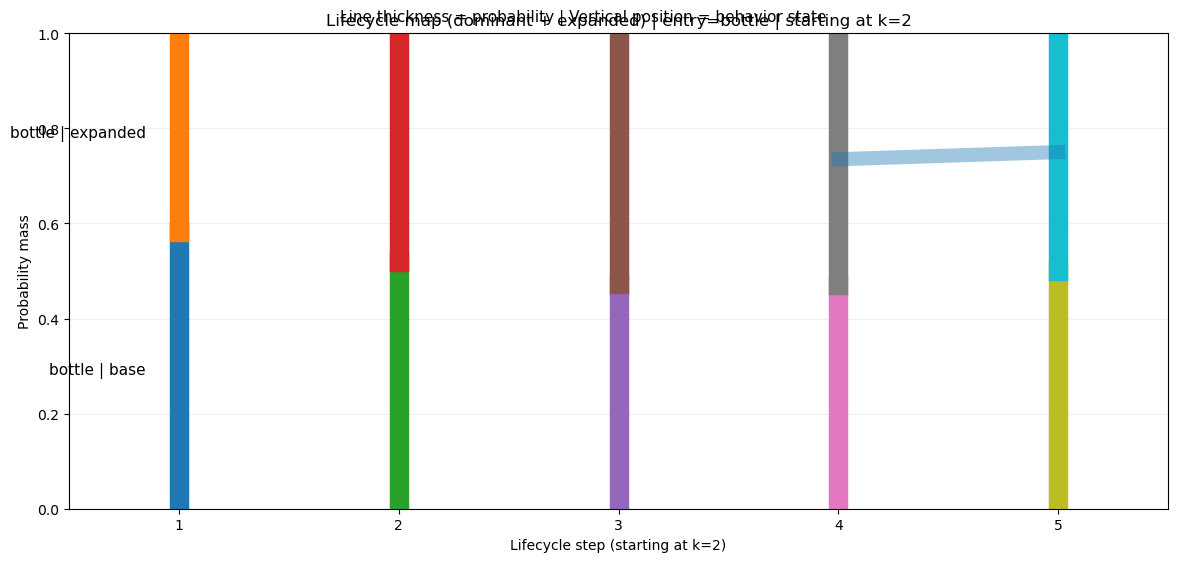

(   step               node      mass
 0     1      bottle | base  0.582751
 1     1  bottle | expanded  0.417249
 2     2      bottle | base  0.518693
 3     2  bottle | expanded  0.481307
 4     3      bottle | base  0.472699
 5     3  bottle | expanded  0.527301
 6     4      bottle | base  0.470306
 7     4  bottle | expanded  0.529694
 8     5      bottle | base  0.500451
 9     5  bottle | expanded  0.499549,
             src_node           dst_node      mass  step
 0      bottle | base      bottle | base  0.489510     1
 1      bottle | base  bottle | expanded  0.079678     1
 2  bottle | expanded  bottle | expanded  0.374550     1
 3      bottle | base      bottle | base  0.442352     2
 4      bottle | base  bottle | expanded  0.061715     2)

In [65]:
entry_dom = "bottle"   # try: "pitcher", "sink", "CO2", etc.

nodes_df, edges_df = build_lifecycle_flow_from_k2(
    df,
    entry_dom=entry_dom,
    k_start=2,
    k_max=6,
    keep_mass=0.95,
    edge_min=0.02
)




plot_lifecycle_map(
    nodes_df,
    edges_df,
    title=f"Lifecycle map (dominant + expanded) | entry={entry_dom} | starting at k=2"
)

nodes_df, edges_df.head()
